In [ ]:
import numpy as np
import h5py
import math
import os
import pathlib
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
import torch
import random
import torch.nn as nn
import sklearn
import collections
from sklearn.model_selection import train_test_split
import torch.nn.functional as F
import json
from torch.optim import Adam
import pylab
from scipy.optimize import curve_fit
from google.colab import drive
drive.mount('/content/gdrive')
import sys
sys.path.insert(0,'/content/gdrive/MyDrive/Penn/Colab/Data/')
from functions import load_model, save_model, Dataset, mse_loss
from sklearn.metrics import roc_curve, auc

Mounted at /content/gdrive


## Classes and Functions

In [ ]:
# Dataset class
class Dataset(torch.utils.data.Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, index):
        return [torch.from_numpy(self.X[index]), torch.from_numpy(self.y[index])]

    def collate_fn(self, batch):
        X = [torch.tensor(sample[0]).float() for sample in batch]
        y = [torch.tensor(sample[1]).float() for sample in batch]
        return torch.stack(X, 0), torch.stack(y, 0)

    def create_dataloader(self, batch_size, shuffle=False, sampler=None):
        return torch.utils.data.DataLoader(
            dataset=self, batch_size=batch_size, collate_fn=self.collate_fn,
            shuffle=shuffle, sampler=sampler)

In [ ]:
def calculate_pt_sum(x_in):
    """Calculate the sum of the pT of all objects for each event.
    Takes in [N, 57] and returns [N]."""

    x = x_in.reshape(-1, 19, 3, 1)
    pT = x[:, 1:, 0, 0]
    pT_sum = np.sum(pT, axis=1)
    return pT_sum

In [ ]:
def plot_hist(pT_sum, bins, log=True):
    freq, bin_edges = np.histogram(pT_sum, bins=bins)
    widths = bin_edges[1:]-bin_edges[:-1]
    plt.figure(figsize=(8, 4))
    plt.rcParams['axes.linewidth'] = 2.4
    plt.grid(zorder=0)
    plt.bar(bin_edges[:-1], freq, width=widths, color='mediumvioletred', edgecolor='k', linewidth=2.3, zorder=2, align='edge')
    if log:
        plt.yscale('log')
    plt.xlabel('Total pT in Event', fontsize=15)
    plt.ylabel('Frequency', fontsize=15)
    plt.title(f'pT Histogram', fontsize=18)
    plt.show()

In [ ]:
def calculate_class_weights(x_in, bins):
    """Takes in (usually) X_train, and calculates an array of the weights for each bin.
    Returns an array of size (bins,)."""
    pT_sum = calculate_pT_sum(x_in)

    freq, bin_edges = np.histogram(pT_sum, bins=bins)
    indxs = np.digitize(pT_sum, bin_edges[:-1]) - 1


    class_weights = 1 / freq
    class_weights[np.isinf(class_weights)] = 0.0

    return class_weights

In [ ]:
def calculate_weights(x_in, bins, class_weights, hist=False):
    """Takes in any array and calculates the weight of each item according to the class_weights array.
    Returns an array of size (x_in,)"""
    pT_sum = calculate_pT_sum(x_in)

    freq, bin_edges = np.histogram(pT_sum, bins=bins)
    #bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

    widths = bin_edges[1:]-bin_edges[:-1]
    widths[-1] = 10000


    # Plot
    if hist:
        plt.figure(figsize=(8, 4))
        plt.rcParams['axes.linewidth'] = 2.4
        plt.grid(zorder=0)
        plt.bar(bin_edges[:-1], freq, width=widths, color='mediumvioletred', edgecolor='k', linewidth=2.3, zorder=2, align='edge')
        plt.yscale('log')
        plt.xlabel('Total pT in Event', fontsize=15)
        plt.ylabel('Frequency', fontsize=15)
        plt.title(f'pT Histogram', fontsize=18)
        plt.xlim(-50, 3000)
        plt.show()


    indxs = np.digitize(pT_sum, bin_edges[:-1]) - 1

    weights = class_weights[indxs]

    return weights

In [ ]:
# Split data into two categories based on pT
def split_data(x_in, threshold):
    """Splits the data into two categories based on a threshold of the summed pT
    of all objects in event."""
    pT_sum = calculate_pT_sum(x_in)

    indices_1 = [] # indices of the low pT dataset
    indices_2 = [] # indices of the high pT datset
    for i, pT in enumerate(pT_sum):
        if pT > threshold:
            indices_2.append(i)
        else:
            indices_1.append(i)

    return x_in[indices_1], x_in[indices_2]

## Load Data

In [ ]:
# Load Background data, which will be used for training
filename = 'BKG_dataset.h5'
with h5py.File('/content/gdrive/MyDrive/Penn/Colab/Data/BKG_dataset.h5', 'r') as file:
    X_train = np.array(file['X_train'])
    X_test = np.array(file['X_test'])
    X_val = np.array(file['X_val'])

print(X_train.shape)

(640000, 57)


In [ ]:
# Split data. 1=low pT, 2=high pT
PT_THRESHOLD = 300
X_train_1, X_train_2 = split_data(X_train, PT_THRESHOLD)
X_val_1, X_val_2 = split_data(X_val, PT_THRESHOLD)

print(f'X_train_1 shape: {X_train_1.shape}')
print(f'X_train_2 shape: {X_train_2.shape}')
print(f'X_val_1 shape: {X_val_1.shape}')
print(f'X_val_2 shape: {X_val_2.shape}')

X_train_1 shape: (635555, 57)
X_train_2 shape: (4445, 57)
X_val_1 shape: (158923, 57)
X_val_2 shape: (1077, 57)


In [ ]:
# Initialize datasets
train_dataset_1 = Dataset(X=X_train_1, y=X_train_1)
train_dataset_2 = Dataset(X=X_val_2, y=X_val_2)
val_dataset_1 = Dataset(X=X_val_1, y=X_val_1)
val_dataset_2 = Dataset(X=X_val_2, y=X_val_2)
test_dataset = Dataset(X=X_test, y=X_test)

In [ ]:
BATCH_SIZE_1 = 1024
BATCH_SIZE_2 = 32

In [ ]:
# Initialize dataloaders
train_loader_1 = train_dataset_1.create_dataloader(batch_size=BATCH_SIZE_1, shuffle=True)
train_loader_2 = train_dataset_2.create_dataloader(batch_size=BATCH_SIZE_2, shuffle=True)
test_loader = test_dataset.create_dataloader(batch_size=BATCH_SIZE_1, shuffle=False)
val_loader_1 = val_dataset_1.create_dataloader(batch_size=BATCH_SIZE_1, shuffle=False)
val_loader_2 = val_dataset_2.create_dataloader(batch_size=BATCH_SIZE_2, shuffle=False)
batch_X, batch_y = next(iter(train_loader_1))
print ("Sample batch:\n"
    f"  X: {list(batch_X.size())}\n"
    f"  y: {list(batch_y.size())}\n")

Sample batch:
  X: [1024, 57]
  y: [1024, 57]



<ipython-input-105-88abfe6357ad>:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = [torch.tensor(sample[0]).float() for sample in batch]
<ipython-input-105-88abfe6357ad>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = [torch.tensor(sample[1]).float() for sample in batch]


## DNN and Trainer Classes

In [ ]:
class DNN_AE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        """input_dim: dimension of the input data.
        latent_dim: dimension of the latent space. Should be smaller than all of the other layers.
        num_nodes: two element array containing the number of nodes in the two hidden layers."""
        super(DNN_AE, self).__init__()

        # Encoder layers
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, latent_dim)

        # Decoder layers
        self.fc3 = nn.Linear(latent_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, input_dim)

    def forward(self, x_in):
        """Forward through the autoencoder with relu activation."""

        # Encoder
        z = F.relu(self.fc1(x_in))
        z = F.relu(self.fc2(z))

        # Decoder
        z = F.relu(self.fc3(z))
        z = self.fc4(z)
        return z

In [ ]:
class Trainer(object):
    def __init__(self, model, num_batches_avg, loss_fn=None, optimizer=None, scheduler=None):
        """num_batches_avg: Number of batches to calculate the average loss over.
        example: if there are 625 batches, we might want to use 25, to calculate
        average loss over 25 batches."""

        #Set params
        self.model = model
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.num_batches_avg = num_batches_avg

    def train_step(self, dataloader):
        """Train for one epoch."""

        self.model.train()
        current_loss = 0.0 # Average loss of most recent batch
        avg_loss = 0.0 # Average loss over a certain number of batches
        running_loss = 0.0

        # Iterate over batches in dataloader
        for i, batch in enumerate(dataloader):

            # Pass a single batch through the model and update the weights
            inputs, targets = batch
            self.optimizer.zero_grad()
            outputs = self.model(inputs)
            loss = self.loss_fn(outputs, targets)
            loss.backward()
            self.optimizer.step()

            # Update loss metrics
            running_loss += loss.item()
            current_loss = loss.item()

            # Calculate the average loss
            if i % self.num_batches_avg == self.num_batches_avg - 1:
                avg_loss = running_loss / self.num_batches_avg
                running_loss = 0.0

        return avg_loss, current_loss

    def eval_step(self, dataloader):
        """validation or test step over one epoch."""

        self.model.eval()
        current_loss = 0.0 # Average loss of most recent batch
        avg_loss = 0.0 # Average loss over a certain number of batches
        running_loss = 0.0
        y_trues, model_outputs = [], []

        # Iterate over val batches
        with torch.no_grad():
            for i, batch in enumerate(dataloader):

                # Pass a single batch through the model
                inputs, y_true = batch
                outputs = self.model(inputs)
                loss = self.loss_fn(outputs, y_true)

                # Update loss metrics
                running_loss += loss.item()
                current_loss = loss.item()

                # Calculate the average loss
                if i % self.num_batches_avg == self.num_batches_avg - 1:
                    avg_loss = running_loss / self.num_batches_avg
                    running_loss = 0.0

                # Store outputs
                y_trues.extend(y_true)
                model_outputs.extend(outputs)
        return avg_loss, current_loss, np.vstack(y_trues), np.vstack(model_outputs)

    def predict_step(self, dataloader):
        """Prediction step."""
        self.model.eval()
        model_outputs = []
        model_inputs = []
        # Iterate over batches
        with torch.no_grad():
            for i, batch in enumerate(dataloader):

                # Pass a single batch through the model
                inputs, targets = batch
                outputs = self.model(inputs)

                # Store outputs
                model_outputs.extend(outputs)
                model_inputs.extend(inputs)

        return np.vstack(model_outputs), np.vstack(model_inputs)

    def train(self, num_epochs, patience, train_dataloader, val_dataloader):
        """Train the neural net."""

        best_val_loss = np.inf

        # Loop over epochs
        for epoch in range(num_epochs):

            # Steps
            avg_train_loss, last_train_loss = self.train_step(dataloader=train_dataloader)
            avg_val_loss, last_val_loss, _, _ = self.eval_step(dataloader=val_dataloader)
            train_loss = last_train_loss
            #train_loss = avg_train_loss
            val_loss = last_val_loss
            #val_loss = avg_val_loss
            self.scheduler.step(val_loss)

            # Early stopping
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_model = self.model
                patience_counter = patience # reset patience
            else:
                patience_counter -= 1
            if not patience_counter: # 0
                print("Stoping Early!")
                break

            # Logging
            print(f'Epoch: {epoch+1} | '
            f'train loss: {train_loss}, '
            f'val loss: {val_loss}, '
            #f'learning rate: {self.optimizer.param_groups[0]['lr']:.2E},'
            f'patience counter: {patience_counter}')

        return best_model

## Initialize Models and Train

In [ ]:
print(f'number of training 1 batches = {len(train_dataset_1) // BATCH_SIZE_1 + 1}')
print(f'number of training 2 batches = {len(train_dataset_2) // BATCH_SIZE_2 + 1}')
print(f'number of val 1 batches = {len(val_dataset_1) // BATCH_SIZE_1 + 1}')
print(f'number of val 2 batches = {len(val_dataset_2) // BATCH_SIZE_2 + 1}')

number of training 1 batches = 621
number of training 2 batches = 34
number of val 1 batches = 156
number of val 2 batches = 34


In [ ]:
# Define consts
LEARNING_RATE = 1e-3
PATIENCE_1 = 6
PATIENCE_2 = 16
NUM_EPOCHS_1 = 20
NUM_EPOCHS_2 = 200
NUM_BATCHES_AVG = 25

In [ ]:
# Initialize model
INPUT_DIM = X_train.shape[1]
HIDDEN_DIM = 32
LATENT_DIM = 8
dense_AE_1 = DNN_AE(input_dim=INPUT_DIM, hidden_dim=10, latent_dim=2)
dense_AE_2 = DNN_AE(input_dim=INPUT_DIM, hidden_dim=HIDDEN_DIM, latent_dim=LATENT_DIM)
print(dense_AE_1.named_parameters)

<bound method Module.named_parameters of DNN_AE(
  (fc1): Linear(in_features=57, out_features=10, bias=True)
  (fc2): Linear(in_features=10, out_features=2, bias=True)
  (fc3): Linear(in_features=2, out_features=10, bias=True)
  (fc4): Linear(in_features=10, out_features=57, bias=True)
)>


In [ ]:
def loss_fn(x, y):
    """Masked MSE Loss"""
    mask = 1 * (y != 0)
    loss = torch.sum(mask * ((x - y) ** 2)) / torch.sum(mask)

    return loss

In [ ]:
# Optimizers
optimizer_1 = Adam(params=dense_AE_1.parameters(), lr=LEARNING_RATE)
optimizer_2 = Adam(params=dense_AE_2.parameters(), lr=LEARNING_RATE)

# LR Schedulers
scheduler_1 = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer_1, mode='min', factor=0.2, patience=3, verbose=True)
scheduler_2 = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer_2, mode='min', factor=0.2, patience=7, verbose=True)

# Trainers
trainer_1 = Trainer(model=dense_AE_1, num_batches_avg=NUM_BATCHES_AVG,
                  loss_fn=loss_fn, optimizer=optimizer_1, scheduler=scheduler_1)
trainer_2 = Trainer(model=dense_AE_2, num_batches_avg=NUM_BATCHES_AVG,
                  loss_fn=loss_fn, optimizer=optimizer_2, scheduler=scheduler_2)

In [ ]:
# Train 1
best_model_1 = trainer_1.train(
    num_epochs=NUM_EPOCHS_1, patience=PATIENCE_1,
    train_dataloader=train_loader_1, val_dataloader=val_loader_1)

<ipython-input-105-88abfe6357ad>:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = [torch.tensor(sample[0]).float() for sample in batch]
<ipython-input-105-88abfe6357ad>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = [torch.tensor(sample[1]).float() for sample in batch]


Epoch: 1 | train loss: 60.08158493041992, val loss: 64.7930679321289, patience counter: 6
Epoch: 2 | train loss: 66.66792297363281, val loss: 64.71236419677734, patience counter: 6
Epoch: 3 | train loss: 65.22087097167969, val loss: 64.44107818603516, patience counter: 6
Epoch: 4 | train loss: 68.05943298339844, val loss: 62.28321075439453, patience counter: 6
Epoch: 5 | train loss: 21.772951126098633, val loss: 19.944381713867188, patience counter: 6
Epoch: 6 | train loss: 14.895746231079102, val loss: 19.27367401123047, patience counter: 6
Epoch: 7 | train loss: 22.34275245666504, val loss: 18.843833923339844, patience counter: 6
Epoch: 8 | train loss: 17.845932006835938, val loss: 18.430866241455078, patience counter: 6
Epoch: 9 | train loss: 20.61719512939453, val loss: 17.8115234375, patience counter: 6
Epoch: 10 | train loss: 17.749034881591797, val loss: 17.11537742614746, patience counter: 6
Epoch: 11 | train loss: 18.996543884277344, val loss: 16.48329734802246, patience count

In [ ]:
# Save model 1
# save_model(best_model_1, 'DNN_AE_double_1') # This one is pretty good
save_model(best_model_1, 'DNN_AE_double_3')

In [ ]:
# Load model 1
dense_AE_1 = DNN_AE(input_dim=INPUT_DIM, hidden_dim=10, latent_dim=2)
dense_AE_1 = load_model(dense_AE_1, 'DNN_AE_double_3') # DNN_AE_double_1 is pretty good
trainer_1 = Trainer(model=dense_AE_1, num_batches_avg=NUM_BATCHES_AVG,
                  loss_fn=loss_fn, optimizer=optimizer_1, scheduler=scheduler_1)

In [ ]:
# Train 2
best_model_2 = trainer_2.train(
    num_epochs=NUM_EPOCHS_2, patience=PATIENCE_2,
    train_dataloader=train_loader_2, val_dataloader=val_loader_2)

<ipython-input-2-88abfe6357ad>:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = [torch.tensor(sample[0]).float() for sample in batch]
<ipython-input-2-88abfe6357ad>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = [torch.tensor(sample[1]).float() for sample in batch]


Epoch: 1 | train loss: 108.82929992675781, val loss: 77.95721435546875, patience counter: 16
Epoch: 2 | train loss: 181.39044189453125, val loss: 74.50328063964844, patience counter: 16
Epoch: 3 | train loss: 89.95439147949219, val loss: 69.2392578125, patience counter: 16
Epoch: 4 | train loss: 139.2822723388672, val loss: 60.962284088134766, patience counter: 16
Epoch: 5 | train loss: 82.9785385131836, val loss: 57.48710250854492, patience counter: 16
Epoch: 6 | train loss: 49.74110412597656, val loss: 48.76873016357422, patience counter: 16
Epoch: 7 | train loss: 85.87236022949219, val loss: 47.94916915893555, patience counter: 16
Epoch: 8 | train loss: 111.8190689086914, val loss: 48.85495376586914, patience counter: 15
Epoch: 9 | train loss: 94.77403259277344, val loss: 46.13897705078125, patience counter: 16
Epoch: 10 | train loss: 61.071773529052734, val loss: 48.18779373168945, patience counter: 15
Epoch: 11 | train loss: 85.76174926757812, val loss: 45.159053802490234, patienc

In [ ]:
# Save model 2
save_model(best_model_2, 'DNN_AE_double_2')

In [ ]:
# Load model 2
dense_AE_2 = DNN_AE(input_dim=INPUT_DIM, hidden_dim=HIDDEN_DIM, latent_dim=LATENT_DIM)
dense_AE_2 = load_model(dense_AE_2, 'DNN_AE_double_2')
trainer_2 = Trainer(model=dense_AE_2, num_batches_avg=NUM_BATCHES_AVG,
                  loss_fn=loss_fn, optimizer=optimizer_2, scheduler=scheduler_2)

## Prediction

In [ ]:
def AD_score(y, x):
    # Masked mse AD Score:
    mask = (y != 0)
    _x = x * mask
    _y = y * mask
    return (mse_loss(_y, _x))

In [ ]:
def predict(dataloader, trainer_1, trainer_2):
    prediction_1, inputs_1 = trainer_1.predict_step(dataloader)
    prediction_2, inputs_2 = trainer_2.predict_step(dataloader)

    AD_score_1 = AD_score(prediction_1, inputs_1)
    AD_score_2 = AD_score(prediction_2, inputs_2)

    #return np.amax([(AD_score_1 / np.linalg.norm(AD_score_1)), (AD_score_2 / np.linalg.norm(AD_score_2))], axis=0)
    return np.amin([AD_score_1, AD_score_2], axis=0)
    #return AD_score_2

In [ ]:
# signal labels
signal_labels = ['Ato4l', 'hChToTauNu', 'hToTauTau', 'leptoquark']

# path to signal files
drive_path = '/content/gdrive/MyDrive/Penn/Colab/Data/'
signals_file = [drive_path+label+'_dataset.h5' for label in signal_labels]
print(signals_file)

['/content/gdrive/MyDrive/Penn/Colab/Data/Ato4l_dataset.h5', '/content/gdrive/MyDrive/Penn/Colab/Data/hChToTauNu_dataset.h5', '/content/gdrive/MyDrive/Penn/Colab/Data/hToTauTau_dataset.h5', '/content/gdrive/MyDrive/Penn/Colab/Data/leptoquark_dataset.h5']


In [ ]:
# read signal data
signal_data = []
for i, label in enumerate(signal_labels):
    with h5py.File(signals_file[i], 'r') as file:
        test_data = np.array(file[label])

    signal_dataset = Dataset(X=test_data, y=test_data)
    signal_loader = signal_dataset.create_dataloader(batch_size=len(test_data), shuffle=False)
    signal_data.append(signal_loader)

print(np.array(signal_data).shape)

(4,)


In [ ]:
# compute loss value (true, predicted)
total_loss = []
total_loss.append(predict(test_loader, trainer_1, trainer_2))

for i, signal_loader in enumerate(signal_data):
    total_loss.append(predict(signal_loader, trainer_1, trainer_2))

<ipython-input-105-88abfe6357ad>:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = [torch.tensor(sample[0]).float() for sample in batch]
<ipython-input-105-88abfe6357ad>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = [torch.tensor(sample[1]).float() for sample in batch]


In [ ]:
print(len(total_loss))
print(total_loss[0].shape)
print(total_loss[1].shape)
print(total_loss[2].shape)
print(total_loss[3].shape)
print(total_loss[4].shape)

5
(200000,)
(55969,)
(760272,)
(691283,)
(340544,)


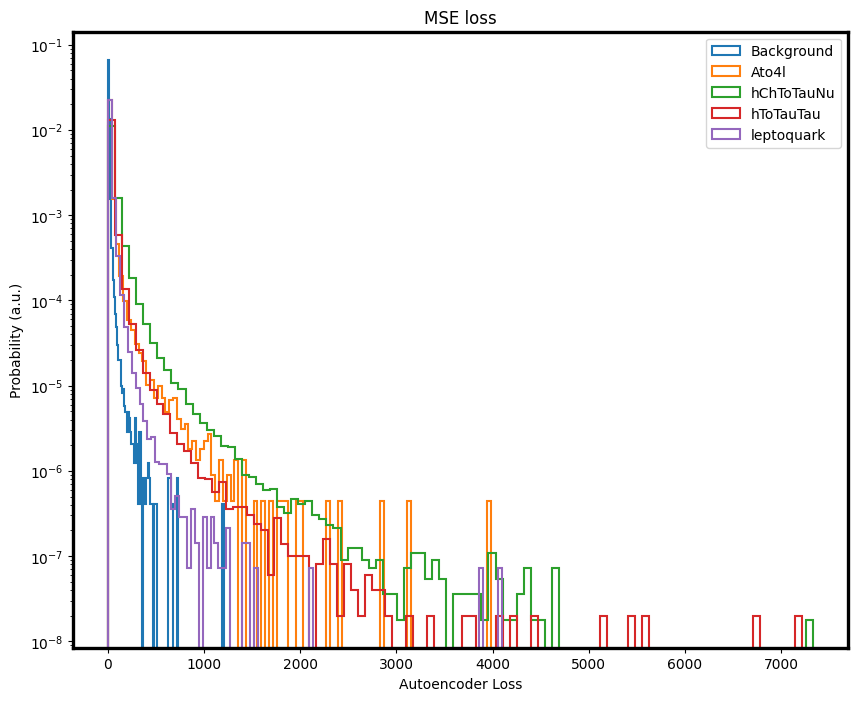

In [ ]:
bin_size=100
labels = np.concatenate([['Background'], np.array(signal_labels)])
plt.figure(figsize=(10,8))
for i, label in enumerate(labels):
    plt.hist(total_loss[i], bins=bin_size, label=label, density = True, histtype='step', fill=False, linewidth=1.5)

#plt.hist(total_loss[0], bins=bin_size, label='background', density = True, histtype='step', fill=False, linewidth=1.5)
#plt.hist(total_loss[1], bins=bin_size, label='Ato4l', density = True, histtype='step', fill=False, linewidth=1.5)
plt.yscale('log')
plt.xlabel("Autoencoder Loss")
plt.ylabel("Probability (a.u.)")
plt.title('MSE loss')
plt.legend(loc='best')
plt.show()

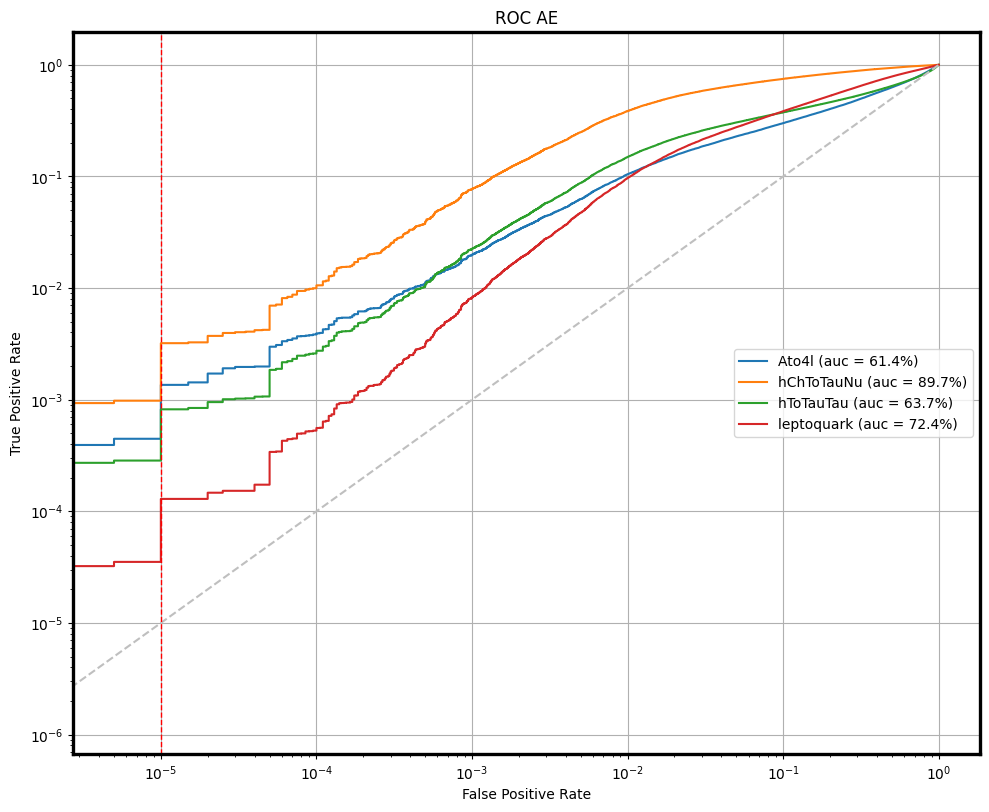

In [ ]:
target_background = np.zeros(total_loss[0].shape[0])

plt.figure(figsize=(10,8))
for i, label in enumerate(labels):
    if i == 0: continue # background events

    trueVal = np.concatenate((np.ones(total_loss[i].shape[0]), target_background)) # anomaly=1, bkg=0
    predVal_loss = np.concatenate((total_loss[i], total_loss[0]))

    fpr_loss, tpr_loss, threshold_loss = roc_curve(trueVal, predVal_loss)

    auc_loss = auc(fpr_loss, tpr_loss)

    plt.plot(fpr_loss, tpr_loss, "-", label='%s (auc = %.1f%%)'%(label,auc_loss*100.), linewidth=1.5)

    plt.semilogx()
    plt.semilogy()
    plt.ylabel("True Positive Rate")
    plt.xlabel("False Positive Rate")
    plt.legend(loc='center right')
    plt.grid(True)
    plt.tight_layout()
plt.plot(np.linspace(0, 1),np.linspace(0, 1), '--', color='0.75')
plt.axvline(0.00001, color='red', linestyle='dashed', linewidth=1) # threshold value for measuring anomaly detection efficiency
plt.title("ROC AE")
plt.show()

## Evaluation

In [ ]:
# Calculate the threshold for a give rejection rate using the background datset

REJECTION_RATE = pow(10, 4)


# Calculate fpr, tpr, thresholds
trueVal = target_background
predVal_loss = np.array(total_loss[0])
fpr_loss, tpr_loss, threshold_loss = roc_curve(trueVal, predVal_loss, drop_intermediate=False)

# Loop over thresholds
for i, thresh in enumerate(threshold_loss):
    preds = (predVal_loss >= thresh)
    rejection_rate = (len(preds) - np.sum(preds)) / np.sum(preds) # number of background / number of anomaly

    # Breaking
    if rejection_rate < REJECTION_RATE:
        break

    threshold = thresh # update threshold

pred_test = (predVal_loss >= threshold)
print(f'\nrejection rate = {(len(pred_test) - np.sum(pred_test)) / np.sum(pred_test):.2f}')
print(f'threshold = {threshold:.2f}\n\n')


rejection rate = 10525.32
threshold = 420.39




/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
<ipython-input-154-ef13861a7d00>:14: RuntimeWarning: divide by zero encountered in long_scalars
  rejection_rate = (len(preds) - np.sum(preds)) / np.sum(preds) # number of background / number of anomaly


In [ ]:
from IPython.display import Javascript
from scipy.stats import beta

<IPython.core.display.Javascript object>


Ato4l:
length of dataset: 55969
TP = 212
TPR = 0.0038



<ipython-input-105-88abfe6357ad>:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = [torch.tensor(sample[0]).float() for sample in batch]
<ipython-input-105-88abfe6357ad>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = [torch.tensor(sample[1]).float() for sample in batch]


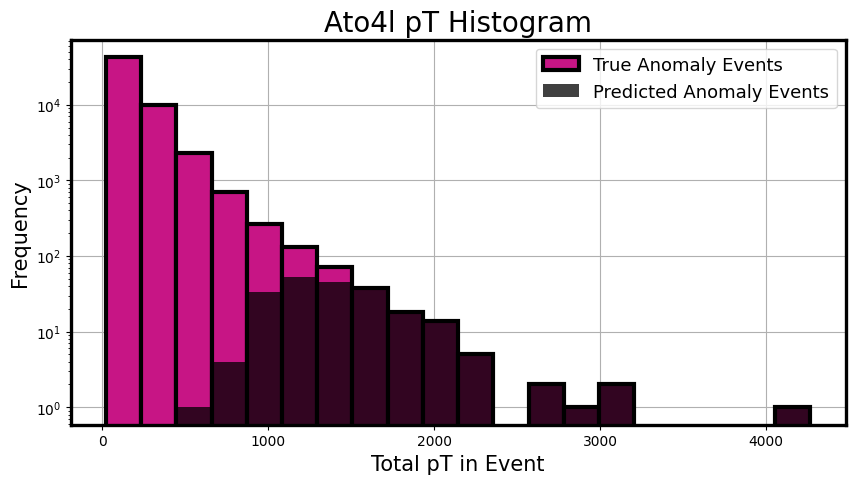


[   0.            0.          129.06738281  341.19729614  553.32720947
  765.45709229  977.5869751  1189.71691895 1401.84680176 1613.97668457
 1826.10668945 2038.23657227 2250.36645508 2462.49633789 2674.6262207
 2886.75610352 3098.88598633 3311.01586914 3523.14599609 3735.27587891
 3947.40576172 4159.53564453 4265.6006012 ]
[0.         1.         1.         0.86300354 0.72503326 0.61475171
 0.52348635 0.4573876  0.40123383 0.34127579 0.27117266 0.24759451
 0.15099634 0.         0.06503058 0.02345483 0.06503058 0.
 0.         0.         0.         0.02345483 0.        ]


<ipython-input-156-e8297b446e75>:80: RuntimeWarning: invalid value encountered in true_divide
  if (pT_hist_B/pT_hist_A)[i] < 0.1: # If statement to deal with nan values when the outputs are too close to 1 or 0
<ipython-input-156-e8297b446e75>:80: RuntimeWarning: invalid value encountered in true_divide
  if (pT_hist_B/pT_hist_A)[i] < 0.1: # If statement to deal with nan values when the outputs are too close to 1 or 0
<ipython-input-156-e8297b446e75>:80: RuntimeWarning: invalid value encountered in true_divide
  if (pT_hist_B/pT_hist_A)[i] < 0.1: # If statement to deal with nan values when the outputs are too close to 1 or 0
<ipython-input-156-e8297b446e75>:80: RuntimeWarning: invalid value encountered in true_divide
  if (pT_hist_B/pT_hist_A)[i] < 0.1: # If statement to deal with nan values when the outputs are too close to 1 or 0
<ipython-input-156-e8297b446e75>:80: RuntimeWarning: invalid value encountered in true_divide
  if (pT_hist_B/pT_hist_A)[i] < 0.1: # If statement to deal wi

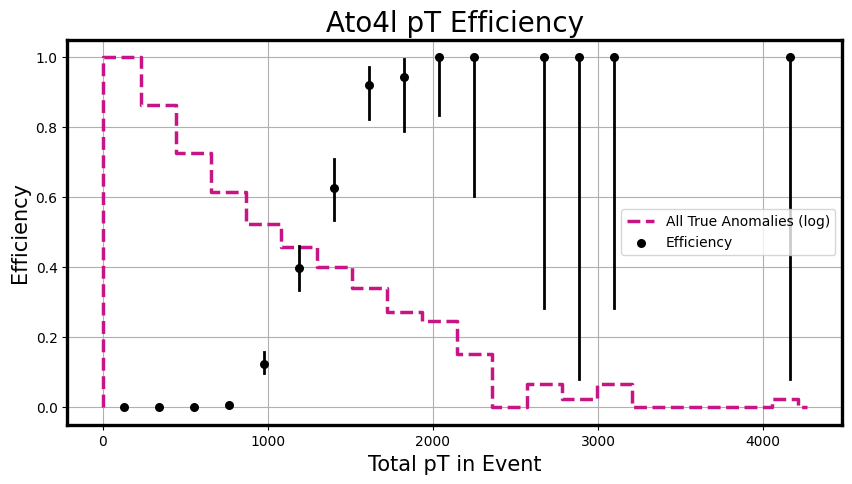

_________________________________________________________________________________________________

hChToTauNu:
length of dataset: 760272
TP = 7487
TPR = 0.0098



<ipython-input-105-88abfe6357ad>:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = [torch.tensor(sample[0]).float() for sample in batch]
<ipython-input-105-88abfe6357ad>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = [torch.tensor(sample[1]).float() for sample in batch]


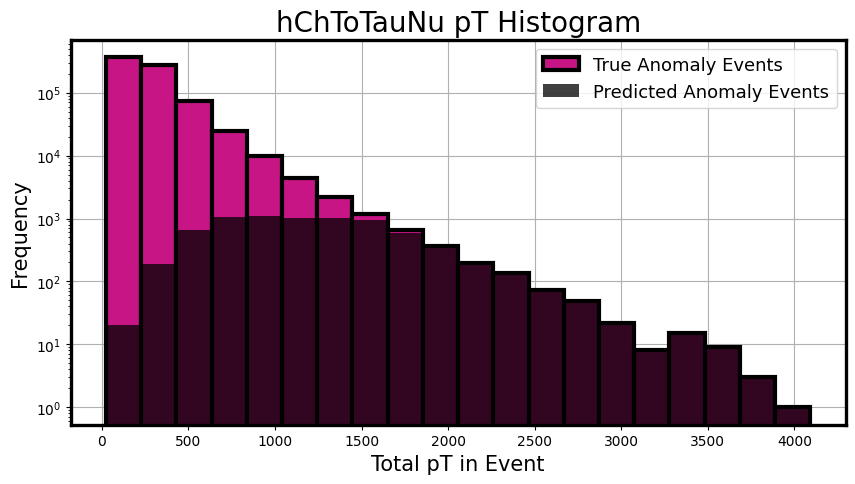


[   0.            0.          124.74861908  328.24105835  531.73352051
  735.22589111  938.71838379 1142.21081543 1345.70324707 1549.19567871
 1752.68811035 1956.18054199 2159.67285156 2363.16552734 2566.65771484
 2770.15039062 2973.64257812 3177.13525391 3380.62744141 3584.12011719
 3787.61230469 3991.10498047 4092.85119629]
[0.         1.         1.         0.9779381  0.87568054 0.78869165
 0.71640825 0.65452759 0.60024433 0.55125291 0.50617064 0.45966766
 0.41317906 0.38460624 0.33490004 0.30217402 0.24127725 0.1623148
 0.21138205 0.17150858 0.08575429 0.01951423 0.        ]


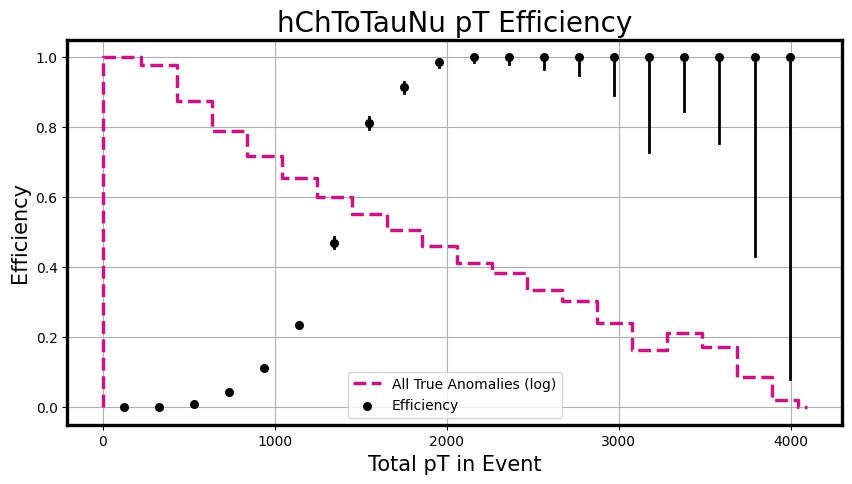

_________________________________________________________________________________________________

hToTauTau:
length of dataset: 691283
TP = 1781
TPR = 0.0026



<ipython-input-105-88abfe6357ad>:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = [torch.tensor(sample[0]).float() for sample in batch]
<ipython-input-105-88abfe6357ad>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = [torch.tensor(sample[1]).float() for sample in batch]


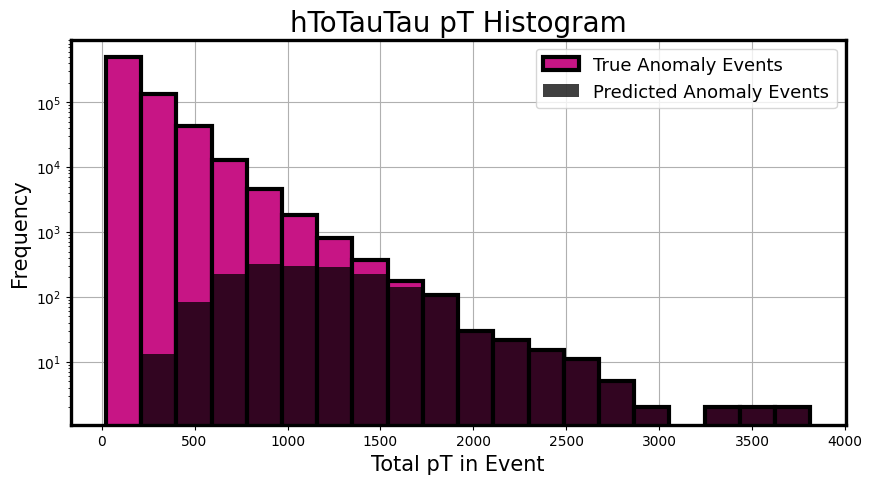


[   0.            0.          117.73540497  307.20550537  496.67565918
  686.14575195  875.61590576 1065.08605957 1254.55615234 1444.02636719
 1633.49645996 1822.96655273 2012.43664551 2201.90673828 2391.37695312
 2580.84716797 2770.31713867 2959.78735352 3149.25732422 3338.72753906
 3528.19775391 3717.66772461 3812.40278625]
[0.         1.         1.         0.90160195 0.81257552 0.72315511
 0.6443499  0.57417033 0.51085743 0.45034269 0.3931715  0.35722421
 0.25949509 0.23583175 0.20661128 0.18294794 0.12279241 0.05288381
 0.         0.05288381 0.05288381 0.05288381 0.        ]


<ipython-input-156-e8297b446e75>:80: RuntimeWarning: invalid value encountered in true_divide
  if (pT_hist_B/pT_hist_A)[i] < 0.1: # If statement to deal with nan values when the outputs are too close to 1 or 0
<ipython-input-156-e8297b446e75>:80: RuntimeWarning: invalid value encountered in true_divide
  if (pT_hist_B/pT_hist_A)[i] < 0.1: # If statement to deal with nan values when the outputs are too close to 1 or 0
<ipython-input-156-e8297b446e75>:80: RuntimeWarning: invalid value encountered in true_divide
  if (pT_hist_B/pT_hist_A)[i] < 0.1: # If statement to deal with nan values when the outputs are too close to 1 or 0
<ipython-input-156-e8297b446e75>:80: RuntimeWarning: invalid value encountered in true_divide
  if (pT_hist_B/pT_hist_A)[i] < 0.1: # If statement to deal with nan values when the outputs are too close to 1 or 0
<ipython-input-156-e8297b446e75>:80: RuntimeWarning: invalid value encountered in true_divide
  if (pT_hist_B/pT_hist_A)[i] < 0.1: # If statement to deal wi

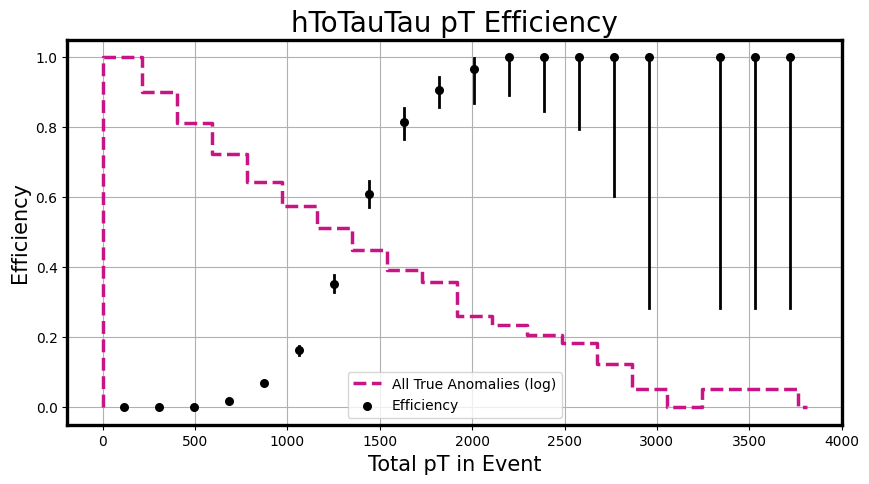

_________________________________________________________________________________________________

leptoquark:
length of dataset: 340544
TP = 178
TPR = 0.0005



<ipython-input-105-88abfe6357ad>:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = [torch.tensor(sample[0]).float() for sample in batch]
<ipython-input-105-88abfe6357ad>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = [torch.tensor(sample[1]).float() for sample in batch]


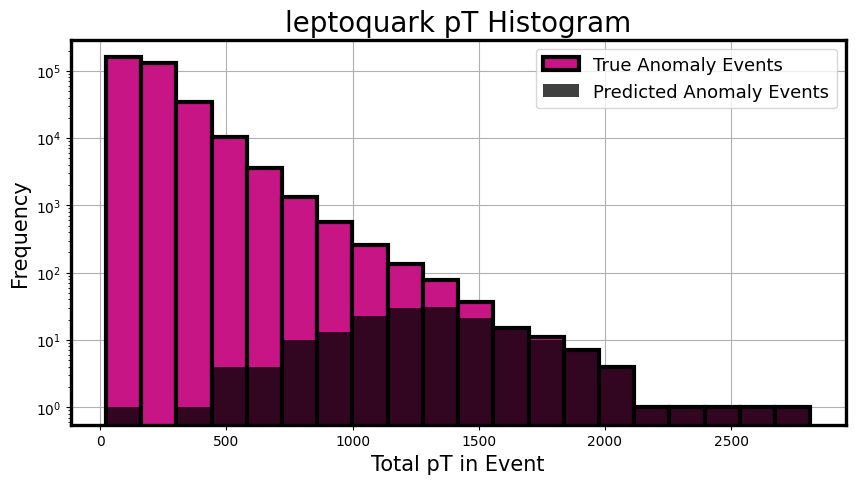


[   0.            0.           92.77263641  232.30809021  371.84353638
  511.37896729  650.91442871  790.4498291   929.98535156 1069.52075195
 1209.05615234 1348.5916748  1488.1270752  1627.66247559 1767.19799805
 1906.73339844 2046.2689209  2185.80444336 2325.33984375 2464.87524414
 2604.41088867 2743.94628906 2813.71401978]
[0.         1.         1.         0.9835125  0.87338642 0.77073453
 0.68421196 0.60191268 0.52970923 0.46463325 0.41020297 0.36270447
 0.29922113 0.22612015 0.20022244 0.16248203 0.11575453 0.02087481
 0.02087481 0.02087481 0.02087481 0.02087481 0.        ]


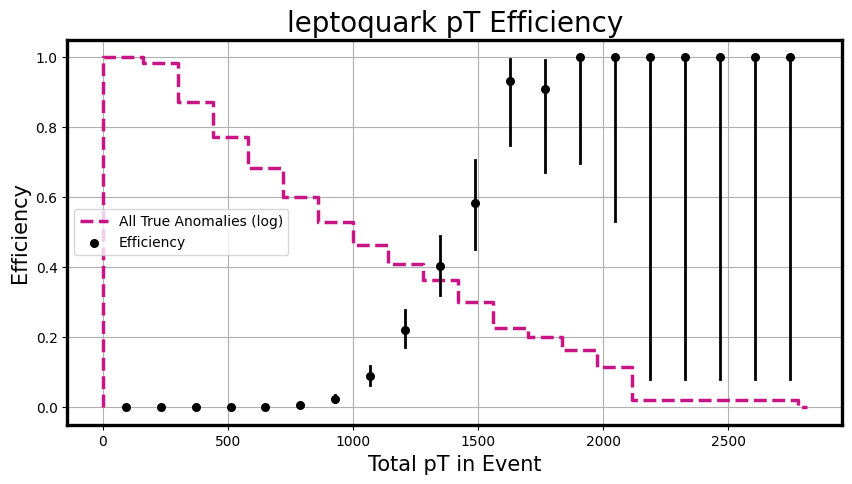

_________________________________________________________________________________________________


In [ ]:
# Calcalate the TPR and efficiency of each signal dataset


display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 20000})''')) # No scroll bar

# Loop over signal datasets
for i, label in enumerate(labels):
    if i ==0: continue # background

    # Calculate TPR
    trueVal = np.concatenate((np.ones(total_loss[i].shape[0]), target_background)) # anomaly=1, bkg=0
    true_indices = np.nonzero(trueVal)[0] # true anomaly indices
    predVal = 1 * (np.concatenate((total_loss[i], total_loss[0])) >= threshold) # 1=anomaly, 0=bkg
    pred_indices = np.nonzero(predVal)[0] # indices of anomaly prediction
    correct_pred_indices = np.intersect1d(pred_indices, true_indices)
    TP = len(np.intersect1d(pred_indices, true_indices)) # the number of elements shared between trueVal and predVal
    TPR = TP / np.sum(trueVal)

    # Printing
    print(f'\n{label}:')
    print(f'length of dataset: {total_loss[i].shape[0]}')
    print(f'TP = {TP}')
    print(f'TPR = {TPR:.4f}\n')

    # Get pT from data
    pT_sum = []
    with torch.no_grad():
        for i, batch in enumerate(signal_data[i-1]):
            inputs, targets = batch
            pT_s = calculate_pT_sum(inputs.numpy())
            pT_sum.extend(pT_s)
    pT_sum = np.vstack(pT_sum)




    # Make histograms
    pT_hist_A, edges_A = np.histogram(pT_sum[true_indices], bins=20) # all events
    pT_hist_B, edges_B = np.histogram(pT_sum[correct_pred_indices], bins=20, range=(pT_sum.min(), pT_sum.max())) # only events predicted as anomalous
    bin_centers = edges_A[0:-1] + ((edges_A[1] - edges_A[0])/2)


    # Plot Histograms
    plt.figure(figsize=(10, 5))
    plt.rcParams['axes.linewidth'] = 2.4
    plt.grid(zorder=0)
    plt.title(f'{label} pT Histogram', fontsize=20)
    plt.xlabel('Total pT in Event', fontsize=15)
    plt.ylabel('Frequency', fontsize=15)
    plt.bar(bin_centers, pT_hist_A, width=(edges_A[1] - edges_A[0]), color='mediumvioletred', edgecolor='k', linewidth=3, zorder=2, label='True Anomaly Events')
    plt.bar(bin_centers, pT_hist_B, width=(edges_A[1] - edges_A[0]), color='k', zorder=3, label='Predicted Anomaly Events', alpha=0.75)
    plt.yscale('log')
    plt.legend(fontsize=13)
    plt.show()
    print('')

    # Plot Efficiency
    plt.figure(figsize=(10, 5))
    plt.rcParams['axes.linewidth'] = 2.4
    plt.grid(zorder=0)
    plt.title(f'{label} pT Efficiency', fontsize=20)
    plt.xlabel('Total pT in Event', fontsize=15)
    plt.ylabel('Efficiency', fontsize=15)
    step_x = np.append(np.insert(bin_centers, 0, [0, 0]), bin_centers[-1] + (edges_A[1] - edges_A[0])/2)
    _temp = [np.log(value) if value > 1 else 0.25*value for value in pT_hist_A]
    step_y = np.append(np.insert(_temp/np.amax(_temp), 0, [0, (_temp/np.amax(_temp))[0]]), 0)
    plt.step(step_x, step_y, where='mid', color='mediumvioletred', linestyle='dashed', linewidth=2.5, zorder=2, label='All True Anomalies (log)')
    print(step_x)
    print(step_y)

    # Error Bars
    y_err = np.empty((2, len(pT_hist_A)))
    alpha = 0.16
    for i in range(len(pT_hist_A)):
        k = pT_hist_B[i]
        n = pT_hist_A[i]
        p_u, p_o = beta.ppf([alpha/2, 1 - alpha/2], [k, k + 1], [n - k + 1, n - k])
        y_err[0, i] = p_u
        y_err[1, i] = p_o
        if (pT_hist_B/pT_hist_A)[i] < 0.1: # If statement to deal with nan values when the outputs are too close to 1 or 0
            plt.plot([bin_centers[i], bin_centers[i]], np.nan_to_num([p_u, p_o], nan=0), color='k', linewidth=2)
        else:
            plt.plot([bin_centers[i], bin_centers[i]], np.nan_to_num([p_u, p_o], nan=1), color='k', linewidth=2)

    plt.scatter(bin_centers, pT_hist_B/pT_hist_A, color='k', s=30, zorder=7, label='Efficiency')

    plt.legend()
    plt.show()
    print('_________________________________________________________________________________________________')